In [4]:
!unzip ../data/tensorflow2-question-answering.zip -d ../data

Archive:  ../data/tensorflow2-question-answering.zip
  inflating: ../data/sample_submission.csv  
  inflating: ../data/simplified-nq-test.jsonl  
  inflating: ../data/simplified-nq-train.jsonl  


In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json
import seaborn as sns

%matplotlib inline

In [ ]:
import pandas as pd 
import json
import re
from tqdm.auto import tqdm

In [9]:
class QADataloader:
    def __init__(self, dataset_path, *, limit_dataset=None, drop_columns=None):
        json_lines = []

        with open(dataset_path, 'rt') as input_file:
            tqdm_file = tqdm(input_file, desc=f'Loading data from {dataset_path}:')
            for line_i, file_line in enumerate(tqdm_file):
                if limit_dataset is not None and line_i >= limit_dataset:
                    break
                
                file_line = json.loads(file_line)
                
                if drop_columns is not None:
                    for columns in drop_columns:
                        del file_line[columns]
                
                json_lines.append(file_line)

        self.df = pd.DataFrame(json_lines)
        
        assert len(self), f'Loaded from file {dataset_path} dataset is empty.'
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        try:
            df_row = self.df.loc[indx]
            
            item = {}
            
            document_text = df_row['document_text'].split()
            
            item['document_text'] = df_row['document_text']
            item['question_text'] = df_row['question_text']
            
            annotations = df_row['annotations'][0]
            
            item['yes_no_answer'] = annotations['yes_no_answer']
            
            start = annotations['long_answer']['start_token']
            end = annotations['long_answer']['start_token']
            item['long_answer'] = 'NONE' if start == end else document_text[start:end]
            
            item['short_answers'] = annotations['short_answers']
            
            long_answer_candidates = []
            for d in df_row['long_answer_candidates']:
                if d['top_level']:
                    start = d['start_token']
                    end = d['end_token']
                
                    long_answer_candidates.append(' '.join(document_text[start:end]))
                    
            item['long_answer_candidates'] = long_answer_candidates 
            
        except e:
            raise e
        
        return item

In [294]:
train_dataset.df.head()

,document_text,long_answer_candidates,question_text,annotations
0,Email marketing - Wikipedia <H1> Email marketi...,"[{'start_token': 14, 'top_level': True, 'end_t...",which is the most common use of opt-in e-mail ...,"[{'yes_no_answer': 'NONE', 'long_answer': {'st..."
1,The Mother ( How I Met Your Mother ) - wikiped...,"[{'start_token': 28, 'top_level': True, 'end_t...",how i.met your mother who is the mother,"[{'yes_no_answer': 'NONE', 'long_answer': {'st..."
2,Human fertilization - wikipedia <H1> Human fer...,"[{'start_token': 14, 'top_level': True, 'end_t...",what type of fertilisation takes place in humans,"[{'yes_no_answer': 'NONE', 'long_answer': {'st..."
3,List of National Football League career quarte...,"[{'start_token': 28, 'top_level': True, 'end_t...",who had the most wins in the nfl,"[{'yes_no_answer': 'NONE', 'long_answer': {'st..."
4,Roanoke Colony - wikipedia <H1> Roanoke Colony...,"[{'start_token': 32, 'top_level': True, 'end_t...",what happened to the lost settlement of roanoke,"[{'yes_no_answer': 'NONE', 'long_answer': {'st..."


In [47]:
import os
import subprocess
import linecache
import re


class QADataloaderOptimal:
    def __init__(self, dataset_path, *, delete_tags=True):
        self.dataset_path = dataset_path
        assert os.path.exists(self.dataset_path), f'Dataset file {self.dataset_path} does not exist.'
        
        self.num_elements = int(subprocess.check_output('wc -l ' + self.dataset_path, shell=True).split()[0]) 
        
        self.delete_tags = delete_tags
    
    def __len__(self):
        return self.num_elements
    
    def __getitem__(self, indx):
        try:
            file_line = linecache.getline(self.dataset_path, indx + 1)
            df_row = json.loads(file_line)
            
            item = {}
            
            document_text = df_row['document_text'].split()
            
            item['document_text'] = df_row['document_text']
            item['question_text'] = df_row['question_text']
            
            annotations = df_row['annotations'][0]
            
            item['yes_no_answer'] = annotations['yes_no_answer']
            
            start = annotations['long_answer']['start_token']
            end = annotations['long_answer']['end_token']
            item['long_answer'] = 'NONE' if start == end else document_text[start:end]
            
            item['short_answers'] = annotations['short_answers']
            
            long_answer_candidates = []
            for d in df_row['long_answer_candidates']:
                if d['top_level']:
                    start = d['start_token']
                    end = d['end_token']
                
                    long_answer_candidates.append(' '.join(document_text[start:end]))
                    
            item['long_answer_candidates'] = long_answer_candidates 
            
            if self.delete_tags:
                tag_re = re.compile(r'<[^>]+>')
                document_text = tag_re.sub('', item['document_text'])
                document_text = ' '.join(document_text.split())
                item['document_text'] = document_text
            
        except e:
            raise e
        
        return item

In [53]:
# drop_columns = ['document_url', 'example_id']

train_dataset = QADataloaderOptimal('../data/simplified-nq-train.jsonl', 
                                    delete_tags=False
#                              limit_dataset=100, 
#                              drop_columns=drop_columns
                                   )

In [54]:
len(train_dataset)

307373

In [55]:
item = train_dataset[0]
print(item['yes_no_answer'])

NONE


In [52]:
item['document_text']

"Email marketing - Wikipedia Email marketing Jump to : navigation , search ( hide ) This article has multiple issues . Please help improve it or discuss these issues on the talk page . ( Learn how and when to remove these template messages ) This article needs additional citations for verification . Please help improve this article by adding citations to reliable sources . Unsourced material may be challenged and removed . ( September 2014 ) ( Learn how and when to remove this template message ) This article possibly contains original research . Please improve it by verifying the claims made and adding inline citations . Statements consisting only of original research should be removed . ( January 2015 ) ( Learn how and when to remove this template message ) ( Learn how and when to remove this template message ) Part of a series on Internet marketing Search engine optimization Local search engine optimisation Social media marketing Email marketing Referral marketing Content marketing N

In [56]:
item['document_text']

"Email marketing - Wikipedia <H1> Email marketing </H1> Jump to : navigation , search <Table> <Tr> <Td> </Td> <Td> ( hide ) This article has multiple issues . Please help improve it or discuss these issues on the talk page . ( Learn how and when to remove these template messages ) <Table> <Tr> <Td> </Td> <Td> This article needs additional citations for verification . Please help improve this article by adding citations to reliable sources . Unsourced material may be challenged and removed . ( September 2014 ) ( Learn how and when to remove this template message ) </Td> </Tr> </Table> <Table> <Tr> <Td> </Td> <Td> This article possibly contains original research . Please improve it by verifying the claims made and adding inline citations . Statements consisting only of original research should be removed . ( January 2015 ) ( Learn how and when to remove this template message ) </Td> </Tr> </Table> ( Learn how and when to remove this template message ) </Td> </Tr> </Table> <Table> <Tr> <T

In [51]:
print(*item.keys(), sep='\n')

document_text
question_text
yes_no_answer
long_answer
short_answers
long_answer_candidates


In [31]:
yes_no_answers = []

for i in tqdm(range(len(train_dataset))):
    item = train_dataset[i]
    
    yes_no_answers.append(item['yes_no_answer'])

In [32]:
plt.style.use('seaborn-darkgrid')
plt.style.use('seaborn-poster')

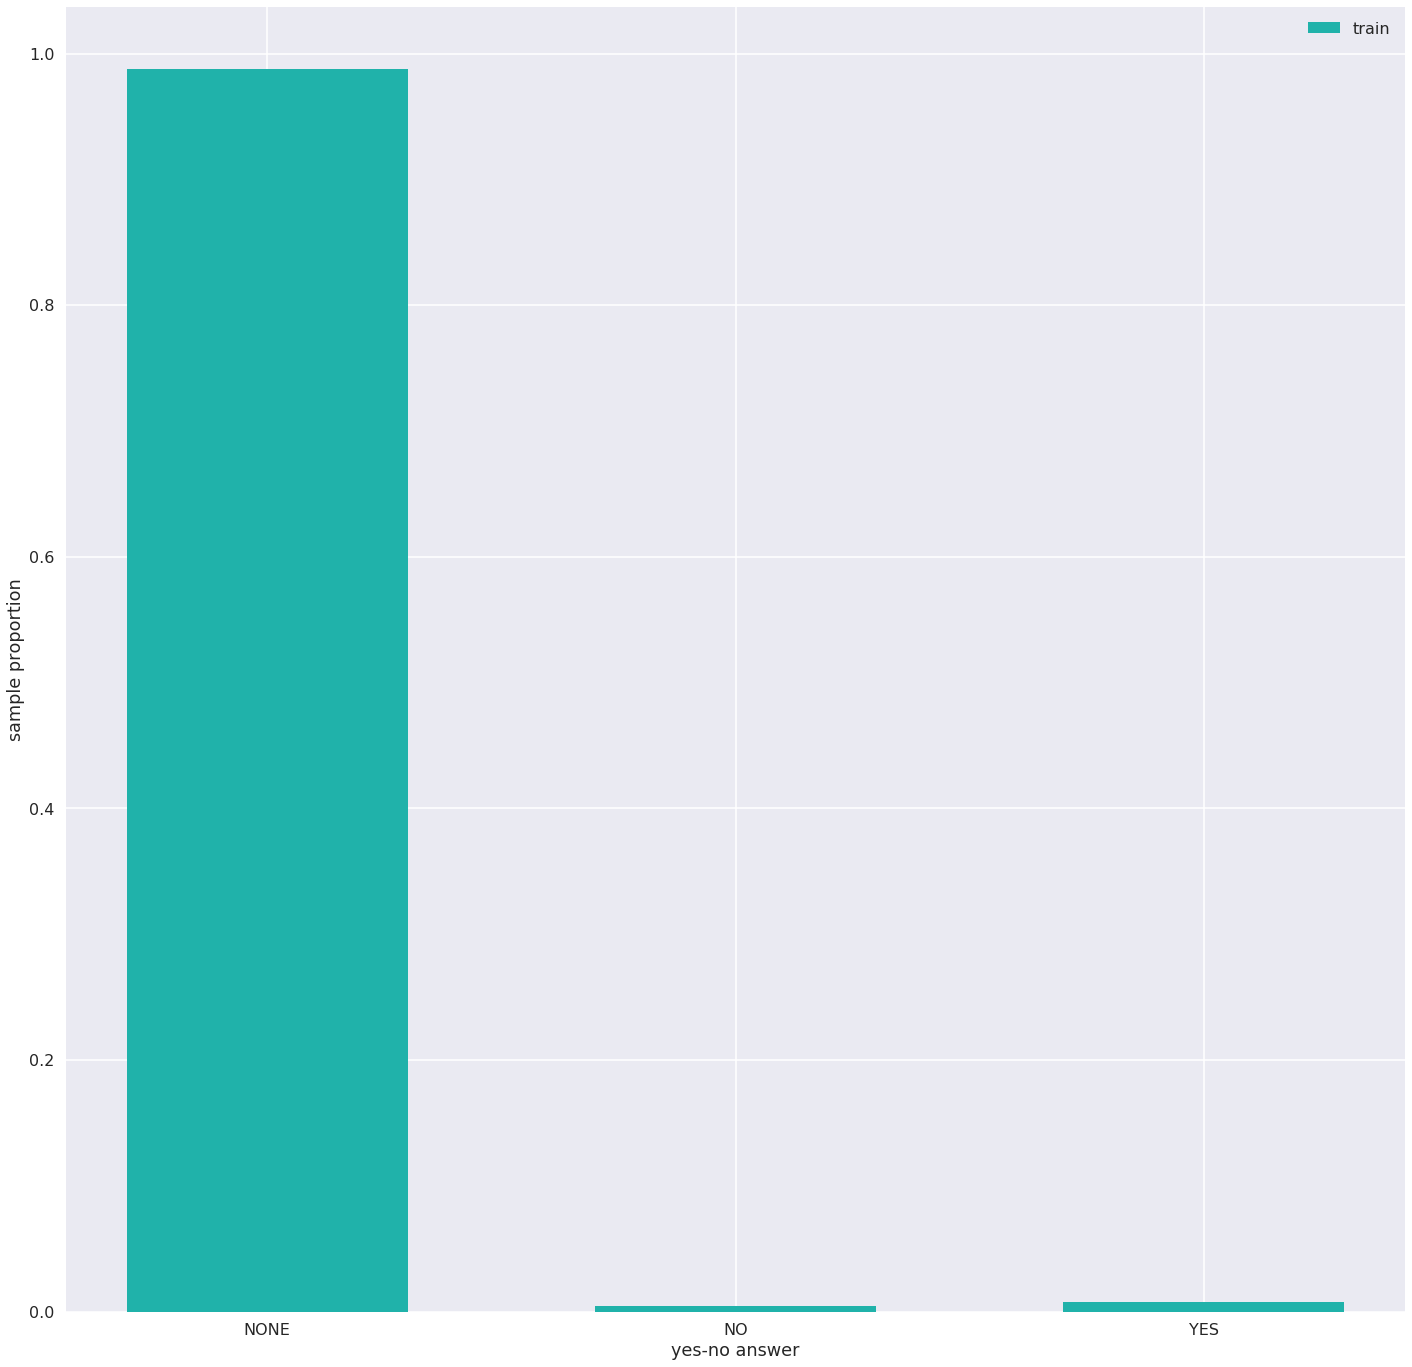

In [33]:
plt.figure(figsize=(24, 24))

plt.hist(yes_no_answers, bins=[0,1,2,3], align='left', density=True, rwidth=0.6, color='lightseagreen', label='train')

plt.xlabel('yes-no answer')
plt.ylabel('sample proportion')

plt.legend()

In [43]:
document_text_lens = []
long_answers = []

for i in tqdm(range(len(train_dataset))):
    item = train_dataset[i]
    
    document_text_lens.append(len(item['document_text'].split()))
    long_answers.append(item['long_answer'] == 'NONE')

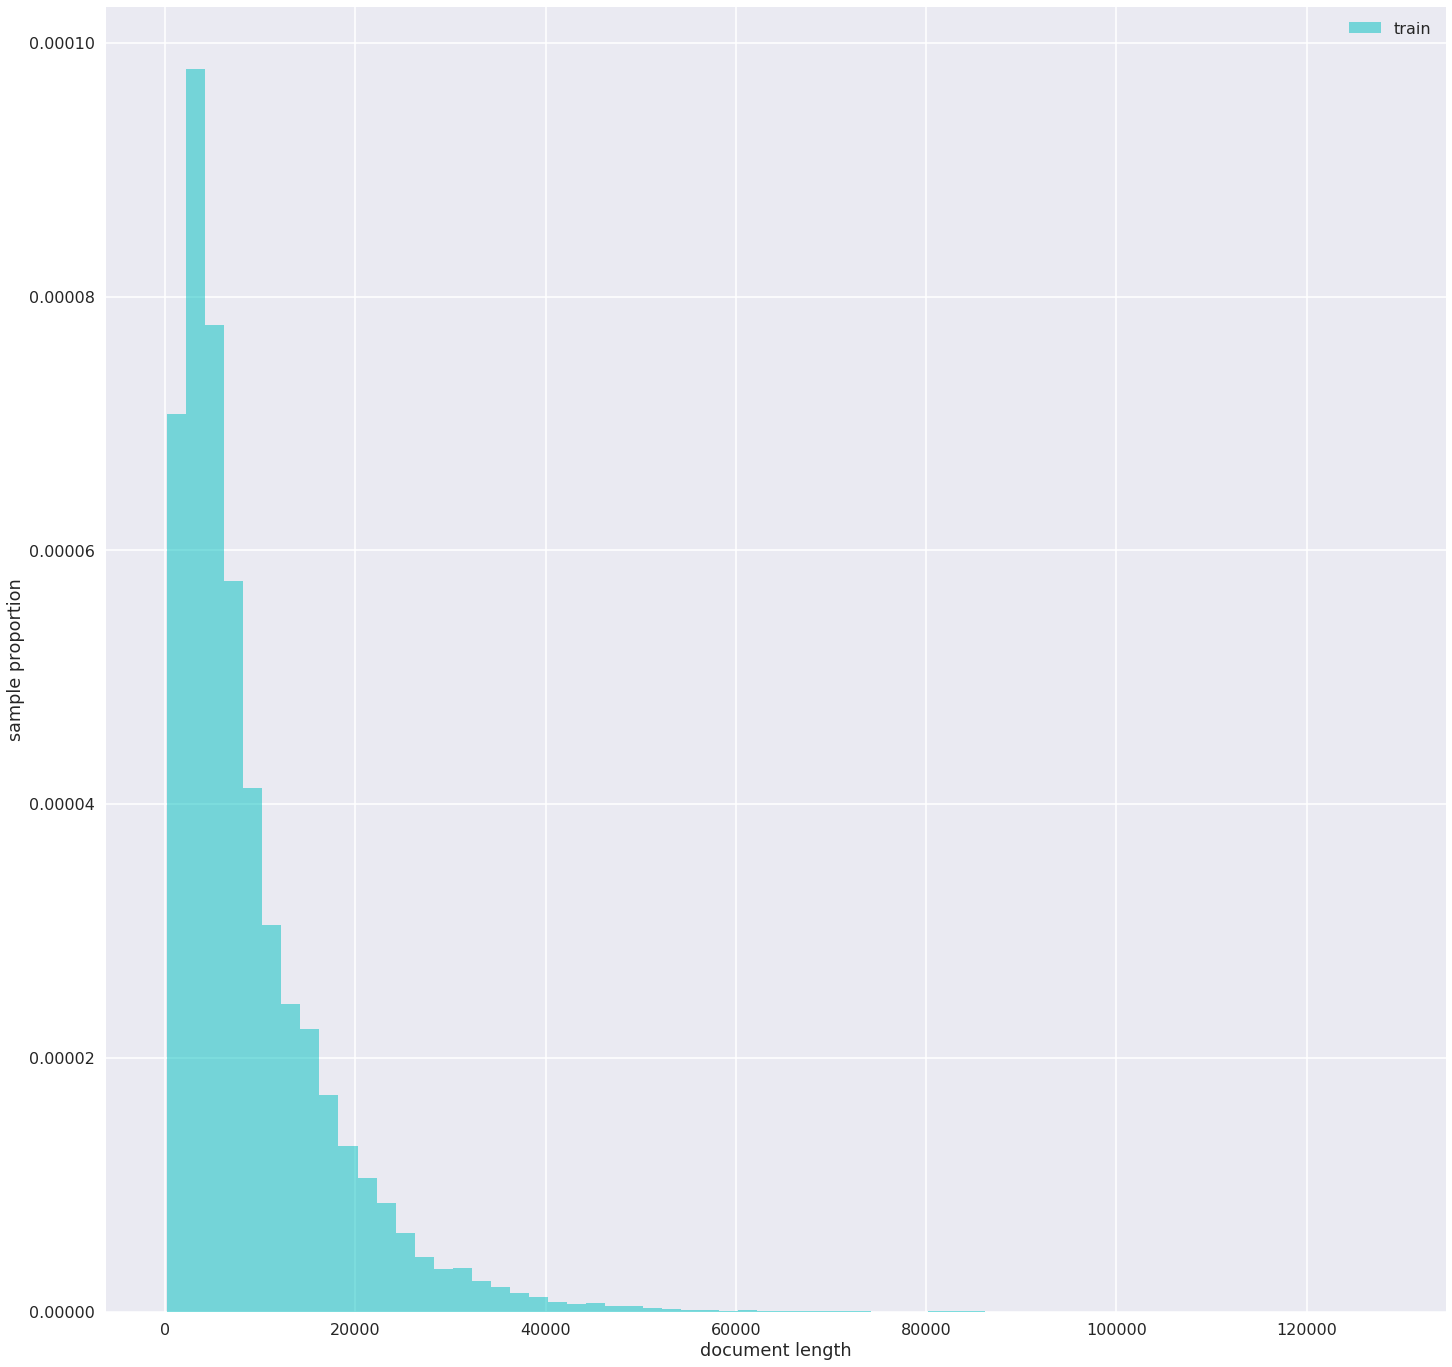

In [44]:
plt.figure(figsize=(24, 24))

plt.hist(document_text_lens, density=True, bins=64, alpha=0.5, color='c', label='train')
plt.xlabel('document length')
plt.ylabel('sample proportion')
plt.legend()

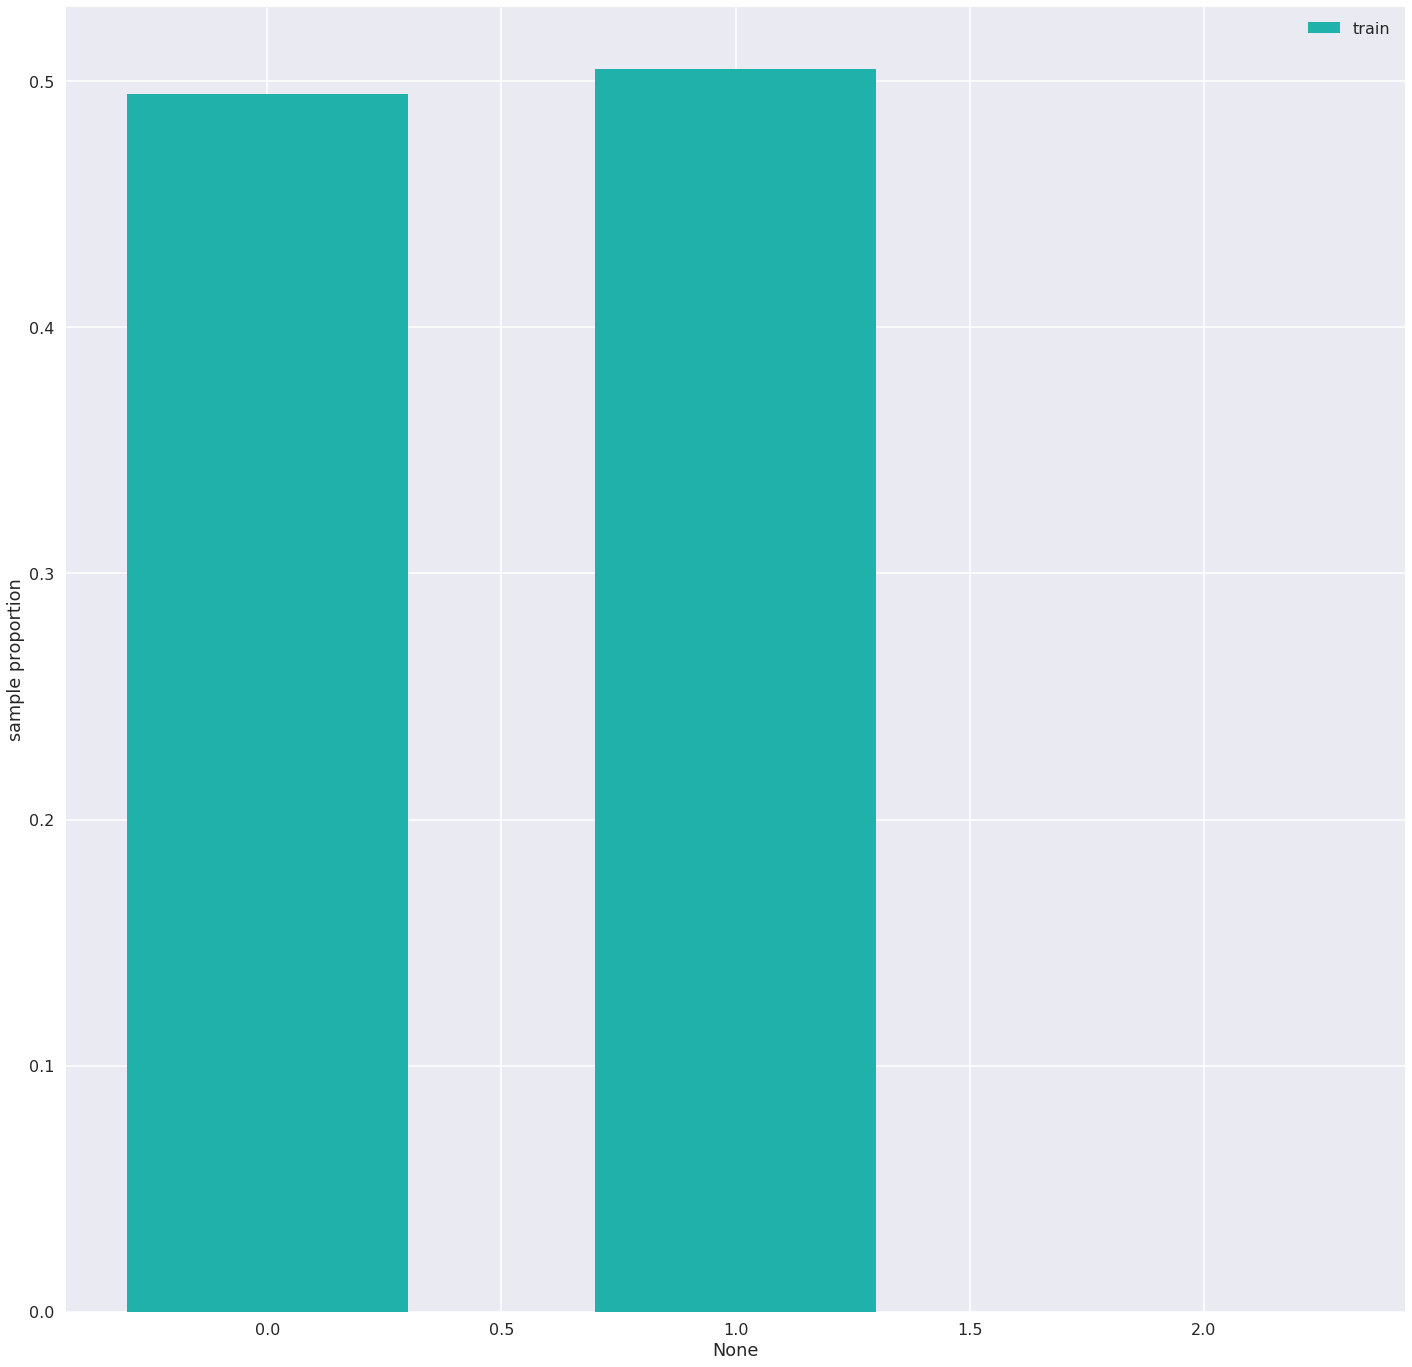

In [46]:
plt.figure(figsize=(24, 24))

plt.hist(long_answers, bins=[0,1,2,3], align='left', density=True, rwidth=0.6, color='lightseagreen', label='train')

plt.xlabel('None')
plt.ylabel('sample proportion')

plt.legend()

In [57]:
bert_model = 'bert-base-uncased'
do_lower_case = 'uncased' in bert_model

In [58]:
from transformers import BertTokenizer

In [59]:
tokenizer = BertTokenizer.from_pretrained(bert_model, do_lower_case=do_lower_case)

In [60]:
tokenizer.all_special_tokens

['[UNK]', '[SEP]', '[CLS]', '[MASK]', '[PAD]']

In [63]:
print(item['question_text'])
print(tokenizer.encode(item['question_text']))
print(tokenizer.decode(tokenizer.encode(item['question_text'])))

which is the most common use of opt-in e-mail marketing
[101, 2029, 2003, 1996, 2087, 2691, 2224, 1997, 23569, 1011, 1999, 1041, 1011, 5653, 5821, 102]
[CLS] which is the most common use of opt - in e - mail marketing [SEP]
